In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import tqdm.notebook as tqdm
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import optim
import torch.nn as nn
from torchvision import datasets
import pip
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, cohen_kappa_score
import copy
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, plot_confusion_matrix
from IPython.display import SVG, display, clear_output

In [ ]:
from google.colab import files

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


*IMAGE TRANSFORMATIONS/DATA AUGMENTATION*

In [23]:
normalize_mean = [0.485,0.456,0.406]
normalize_std = [0.229, 0.224, 0.225]

transform = transforms.Compose([
  transforms.Resize((224,224)),
  transforms.ToTensor(),
  transforms.RandomHorizontalFlip(), 
  transforms.RandomRotation(5),
  transforms.CenterCrop((222,222)),
  transforms.ColorJitter(brightness=0.4, contrast=0.0, saturation=1.2, hue=0.2),
  transforms.Normalize(normalize_mean, normalize_std)
])

In [12]:
transform_original = transforms.Compose([
  transforms.Resize((224,224)),
  transforms.ToTensor()
])

In [5]:
!mkdir -p /my_data/

CARGAMOS LAS IMAGENES

In [6]:
!unzip '/content/drive/MyDrive/COVID_DETECTION/Pneumonia.zip' -d "/my_data"

Archive:  /content/drive/MyDrive/COVID_DETECTION/Pneumonia.zip
   creating: /my_data/Viral Pneumonia/
 extracting: /my_data/Viral Pneumonia/Viral Pneumonia (1).png  
 extracting: /my_data/Viral Pneumonia/Viral Pneumonia (10).png  
 extracting: /my_data/Viral Pneumonia/Viral Pneumonia (100).png  
 extracting: /my_data/Viral Pneumonia/Viral Pneumonia (1000).png  
 extracting: /my_data/Viral Pneumonia/Viral Pneumonia (1001).png  
 extracting: /my_data/Viral Pneumonia/Viral Pneumonia (1002).png  
 extracting: /my_data/Viral Pneumonia/Viral Pneumonia (1003).png  
 extracting: /my_data/Viral Pneumonia/Viral Pneumonia (1004).png  
 extracting: /my_data/Viral Pneumonia/Viral Pneumonia (1005).png  
 extracting: /my_data/Viral Pneumonia/Viral Pneumonia (1006).png  
 extracting: /my_data/Viral Pneumonia/Viral Pneumonia (1007).png  
 extracting: /my_data/Viral Pneumonia/Viral Pneumonia (1008).png  
 extracting: /my_data/Viral Pneumonia/Viral Pneumonia (1009).png  
 extracting: /my_data/Viral Pneum

In [7]:
!unzip '/content/drive/MyDrive/COVID_DETECTION/COVID.zip' -d "/my_data"

Archive:  /content/drive/MyDrive/COVID_DETECTION/COVID.zip
   creating: /my_data/COVID/
   creating: /my_data/COVID/COVID/
 extracting: /my_data/COVID/COVID (1).png  
 extracting: /my_data/COVID/COVID (10).png  
 extracting: /my_data/COVID/COVID (100).png  
 extracting: /my_data/COVID/COVID (1000).png  
 extracting: /my_data/COVID/COVID (1001).png  
 extracting: /my_data/COVID/COVID (1002).png  
 extracting: /my_data/COVID/COVID (1003).png  
 extracting: /my_data/COVID/COVID (1004).png  
 extracting: /my_data/COVID/COVID (1005).png  
 extracting: /my_data/COVID/COVID (1006).png  
 extracting: /my_data/COVID/COVID (1007).png  
 extracting: /my_data/COVID/COVID (1008).png  
 extracting: /my_data/COVID/COVID (1009).png  
 extracting: /my_data/COVID/COVID (101).png  
 extracting: /my_data/COVID/COVID (1010).png  
 extracting: /my_data/COVID/COVID (1011).png  
 extracting: /my_data/COVID/COVID (1012).png  
 extracting: /my_data/COVID/COVID (1013).png  
 extracting: /my_data/COVID/COVID (101

In [8]:
!unzip '/content/drive/MyDrive/COVID_DETECTION/NORMAL.zip' -d "/my_data"

Archive:  /content/drive/MyDrive/COVID_DETECTION/NORMAL.zip
   creating: /my_data/NORMAL/
 extracting: /my_data/NORMAL/NORMAL (1).png  
 extracting: /my_data/NORMAL/NORMAL (10).png  
 extracting: /my_data/NORMAL/NORMAL (100).png  
 extracting: /my_data/NORMAL/NORMAL (1000).png  
 extracting: /my_data/NORMAL/NORMAL (1001).png  
 extracting: /my_data/NORMAL/NORMAL (1002).png  
 extracting: /my_data/NORMAL/NORMAL (1003).png  
 extracting: /my_data/NORMAL/NORMAL (1004).png  
 extracting: /my_data/NORMAL/NORMAL (1005).png  
 extracting: /my_data/NORMAL/NORMAL (1006).png  
 extracting: /my_data/NORMAL/NORMAL (1007).png  
 extracting: /my_data/NORMAL/NORMAL (1008).png  
 extracting: /my_data/NORMAL/NORMAL (1009).png  
 extracting: /my_data/NORMAL/NORMAL (101).png  
 extracting: /my_data/NORMAL/NORMAL (1010).png  
 extracting: /my_data/NORMAL/NORMAL (1011).png  
 extracting: /my_data/NORMAL/NORMAL (1012).png  
 extracting: /my_data/NORMAL/NORMAL (1013).png  
 extracting: /my_data/NORMAL/NORMAL

*PREPARAMOS DATASET

In [ ]:
def myloader(filename):
    return Image.open(filename).convert('RGB')

In [24]:
dataset = datasets.ImageFolder('/my_data', transform=transform)

In [19]:
dataset_sin_data_augmentation = datasets.ImageFolder('/my_data', transform= transform_original)

In [ ]:
#dataset = datasets.ImageFolder('/my_data', transform=transform, loader = myloader)Preguntar lo de image

In [11]:
dataset.classes

['COVID', 'NORMAL', 'Viral Pneumonia']

In [ ]:
print(dataset.class_to_idx) #Clases asignadas en la función imagefolder a las tres carpetas

{'COVID': 0, 'NORMAL': 1, 'Viral Pneumonia': 2}


In [ ]:
dataset

Dataset ImageFolder
    Number of datapoints: 5080
    Root location: /my_data
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               RandomHorizontalFlip(p=0.5)
               ColorJitter(brightness=[0.6, 1.4], contrast=[0.6, 1.4], saturation=[0.6, 1.4], hue=[-0.2, 0.2])
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

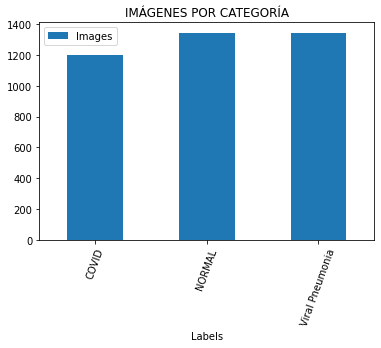

In [ ]:
covid = 1200
normal = 1341
pneumonia = 1345
data = {"Labels":['COVID', 'NORMAL', 'Viral Pneumonia'],

        "Images":[covid,normal,pneumonia]

        };
dataFrame_dataset= pd.DataFrame(data=data);
dataFrame_dataset.plot.bar(x="Labels", y="Images", rot=70, title="IMÁGENES POR CATEGORÍA");

In [ ]:
len(dataset)

5080

DIVIDIMOS DATASET EN TRAIN, VALIDACIÓN Y TEST

In [ ]:
n_train = int(0.7*len(dataset))
n_valid_test = (len(dataset)-n_train)
n_valid = int((0.5*(n_valid_test)))
n_test = int((0.5*(n_valid_test)))

In [ ]:
import matplotlib.pyplot as plt

classes = [[n_train, n_valid, n_test]]
labels = {'Train',  'Validation', 'Test'}

df = pd.DataFrame(classes,columns=labels)
df

,Validation,Train,Test
0,3556,762,762


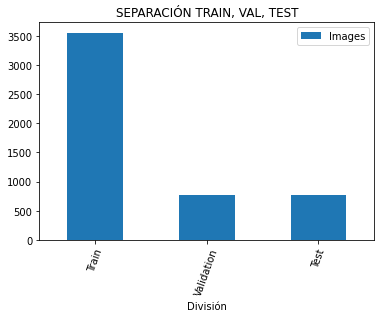

In [ ]:
data = {"División":["Train", "Validation", "Test"],

        "Images":[n_train,n_valid,n_test]

        };
dataFrame = pd.DataFrame(data=data);
dataFrame.plot.bar(x="División", y="Images", rot=70, title="SEPARACIÓN TRAIN, VAL, TEST");

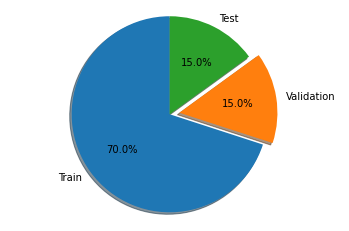

In [ ]:
import matplotlib.pyplot as plt


labels = 'Train', 'Validation', 'Test'
sizes = [n_train, n_valid, n_test]
explode = (0, 0.1, 0)  

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  

plt.show()

In [ ]:
train_ds, val_ds, test_ds = torch.utils.data.random_split(dataset, [n_train, n_valid, n_test])

PREPARAMOS DATALOADER

In [ ]:
batch_size = 128
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle = True)
val_loader = DataLoader(val_ds, batch_size = batch_size, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle = True)

In [ ]:
dataloaders_entrenamiento = {"Train":train_loader, "Validation":val_loader}
data_sizes = {x: len(dataloaders_entrenamiento[x].sampler) for x in ['Train','Validation']}

In [ ]:
datasetheatmap = datasets.ImageFolder('/GRAD_CAM', transform=transform)

In [ ]:
dataloaderheatmap = DataLoader(dataset=datasetheatmap, shuffle=False, batch_size=1)

VISUALIZACIÓN DE LOS DATOS SIN DATA AUGMENTATION

COVID IMAGE:

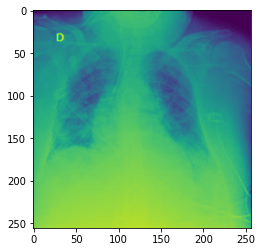

In [ ]:
image = plt.imread('/my_data/COVID/COVID (100).png')
plt.imshow(image)

NORMAL IMAGE:

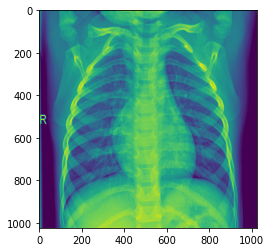

In [ ]:
image = plt.imread('/my_data/NORMAL/NORMAL (1004).png')
plt.imshow(image)

VIRAL PNEUMONIA IMAGE

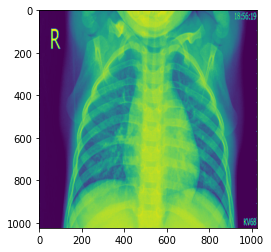

In [ ]:
image = plt.imread('/my_data/Viral Pneumonia/Viral Pneumonia (1030).png')
plt.imshow(image)

VISUALIZACIÓN DE LOS DATOS CON DATA AUGMENTATION

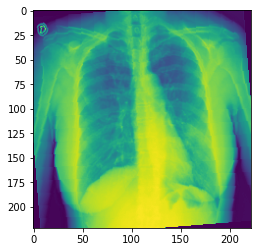

In [25]:
x, _ = dataset[160]
plt.imshow(x.numpy()[0])

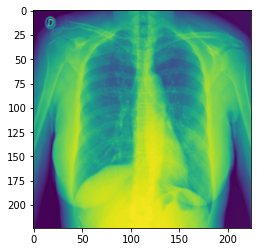

In [20]:
x, _ = dataset_sin_data_augmentation[160] # x is now a torch.Tensor
plt.imshow(x.numpy()[0])

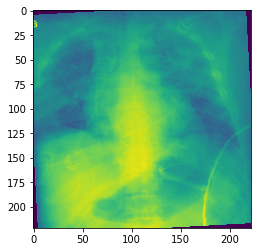

In [29]:
x, _ = dataset[100]
plt.imshow(x.numpy()[0])

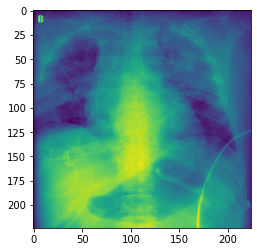

In [28]:
x, _ = dataset_sin_data_augmentation[100]
plt.imshow(x.numpy()[0])

ARQUITECTURA DENSENET

In [30]:
densenet121 = torchvision.models.densenet121(pretrained = True)
print(densenet121)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth



DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

MODIFICACIÓN DEL CLASSIFIER LAYER

In [ ]:
densenet121.fc = nn.Sequential(
    nn.Linear(512,256,True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.3),
    nn.Linear(256,64),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.3),
    nn.Linear(64,3)
)


DEFINIMOS FUNCIÓN DE OPTIMIZACIÓN Y PERDIDA

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(densenet121.parameters(), lr = 0.09)

DEFINIMOS LA GRÁFICA DE ENTRENAMIENTO

In [ ]:
from matplotlib.ticker import MaxNLocator

def grafica_entrenamiento(acc_tr, acc_val, loss_tr, loss_val,
                          figsize=(12,6)):
    plt.figure(figsize=figsize)
    ax = plt.subplot(1,2,1)
    plt.plot(1+np.arange(len(acc_tr)),  100*np.array(acc_tr))
    plt.plot(1+np.arange(len(acc_val)), 100*np.array(acc_val))
    plt.title('tasa de acierto del modelo (%)', fontsize=18)
    plt.ylabel('tasa de acierto (%)', fontsize=18)
    plt.xlabel('época', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.subplot(1,2,2)
    plt.plot(1+np.arange(len(acc_tr)), np.array(loss_tr))
    plt.plot(1+np.arange(len(acc_val)), np.array(loss_val))
    plt.title('loss del modelo', fontsize=18)
    plt.ylabel('loss', fontsize=18)
    plt.xlabel('época', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()

ENTRENAMOS EL MODELO

In [ ]:
def train_covid(densenet121, loss_fn, optimizer, epochs=5):
    loss_tr = []
    acc_tr  = []
    loss_val = []
    acc_val = []
    since = time.time()
    best_loss = np.inf
    best_model_wts = copy.deepcopy(densenet121.state_dict())

    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch+1, epochs))
        print('-' * 5)

        # Cada epoch tendrá una fase de train y otra de validación
        for phase in ['Train', 'Validation']:
            if phase == 'Train':
                densenet121.train()  # Train
            else:
                densenet121.eval()   # Validación

            current_loss = 0.0
            current_acc = 0
            

            #Cogemos los inputs y los almacenamos en un dataloader filtrado por Train y Validation, para poder entrenarlos simultáneamente
            for inputs, labels in tqdm.tqdm(dataloaders_entrenamiento[phase], desc=phase, leave=False):

                #Hacemos 0 los parámetros del gradiente.
                optimizer.zero_grad()

                # BACKWARD PROPAGATION. Se calculan gradientes y se actualizan los pesos
                #Solo se hace el back propagation y se optimiza si es en Train
                with torch.set_grad_enabled(phase == 'Train'):
                    outputs = densenet121(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = loss_fn(outputs, labels)

                    # Solo hacemos el backward y optimizamos en train
                    if phase == 'Train':
                        loss.backward()
                        optimizer.step()

                 # Acumulamos las estadísticas de loss y accuracy en variables
                current_loss += loss.item() * inputs.size(0)
                current_acc += torch.sum(preds == labels.data)
            epoch_loss = current_loss / data_sizes[phase]
            epoch_acc = current_acc.double() / data_sizes[phase]
            if phase == 'Validation':
                print('{} Loss: {:.4f} | {} Accuracy: {:.4f}'.format(
                    phase, epoch_loss, phase, epoch_acc))
                loss_val.append(epoch_loss)
                acc_val.append(epoch_acc)
            else:
                print('{} Loss: {:.4f} | {} Accuracy: {:.4f}'.format(
                    phase, epoch_loss, phase, epoch_acc))
                loss_tr.append(epoch_loss)
                acc_tr.append(epoch_acc)
                print(loss_tr)
                print(acc_tr)

            
            if phase == 'Validation' and epoch_loss < best_loss:
                print('Validation loss decreased from {:.4f} to {:.4f} \nSaving Weights... '.format(best_loss, epoch_loss))
                best_loss = epoch_loss 
                best_model_wts = copy.deepcopy(densenet121.state_dict())

        print()

    time_since = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_since // 60, time_since % 60))
    print('Best val loss: {:.4f}'.format(best_loss))

    
    grafica_entrenamiento(acc_tr, acc_val, loss_tr, loss_val)
    return densenet121

Epoch 1/10
----------


Train Loss: 1.2359 | Train Accuracy: 0.8152
[1.235897312692971]
[tensor(0.8152, dtype=torch.float64)]


Validation Loss: 0.1721 | Validation Accuracy: 0.9331
Validation loss decreased from inf to 0.1721 
Saving Weights... 

Epoch 2/10
----------


Train Loss: 0.0824 | Train Accuracy: 0.9705
[1.235897312692971, 0.08242179735388745]
[tensor(0.8152, dtype=torch.float64), tensor(0.9705, dtype=torch.float64)]


Validation Loss: 0.0695 | Validation Accuracy: 0.9738
Validation loss decreased from 0.1721 to 0.0695 
Saving Weights... 

Epoch 3/10
----------


Train Loss: 0.0520 | Train Accuracy: 0.9848
[1.235897312692971, 0.08242179735388745, 0.05199714969210872]
[tensor(0.8152, dtype=torch.float64), tensor(0.9705, dtype=torch.float64), tensor(0.9848, dtype=torch.float64)]


Validation Loss: 0.0654 | Validation Accuracy: 0.9777
Validation loss decreased from 0.0695 to 0.0654 
Saving Weights... 

Epoch 4/10
----------


Train Loss: 0.0585 | Train Accuracy: 0.9817
[1.235897312692971, 0.08242179735388745, 0.05199714969210872, 0.05845542376624217]
[tensor(0.8152, dtype=torch.float64), tensor(0.9705, dtype=torch.float64), tensor(0.9848, dtype=torch.float64), tensor(0.9817, dtype=torch.float64)]


Validation Loss: 0.0695 | Validation Accuracy: 0.9685

Epoch 5/10
----------


Train Loss: 0.0399 | Train Accuracy: 0.9862
[1.235897312692971, 0.08242179735388745, 0.05199714969210872, 0.05845542376624217, 0.03993764646242386]
[tensor(0.8152, dtype=torch.float64), tensor(0.9705, dtype=torch.float64), tensor(0.9848, dtype=torch.float64), tensor(0.9817, dtype=torch.float64), tensor(0.9862, dtype=torch.float64)]


Validation Loss: 0.0628 | Validation Accuracy: 0.9764
Validation loss decreased from 0.0654 to 0.0628 
Saving Weights... 

Epoch 6/10
----------


Train Loss: 0.0205 | Train Accuracy: 0.9924
[1.235897312692971, 0.08242179735388745, 0.05199714969210872, 0.05845542376624217, 0.03993764646242386, 0.020506833387691742]
[tensor(0.8152, dtype=torch.float64), tensor(0.9705, dtype=torch.float64), tensor(0.9848, dtype=torch.float64), tensor(0.9817, dtype=torch.float64), tensor(0.9862, dtype=torch.float64), tensor(0.9924, dtype=torch.float64)]


Validation Loss: 0.0477 | Validation Accuracy: 0.9829
Validation loss decreased from 0.0628 to 0.0477 
Saving Weights... 

Epoch 7/10
----------


Train Loss: 0.0136 | Train Accuracy: 0.9969
[1.235897312692971, 0.08242179735388745, 0.05199714969210872, 0.05845542376624217, 0.03993764646242386, 0.020506833387691742, 0.013580987399655601]
[tensor(0.8152, dtype=torch.float64), tensor(0.9705, dtype=torch.float64), tensor(0.9848, dtype=torch.float64), tensor(0.9817, dtype=torch.float64), tensor(0.9862, dtype=torch.float64), tensor(0.9924, dtype=torch.float64), tensor(0.9969, dtype=torch.float64)]


Validation Loss: 0.0366 | Validation Accuracy: 0.9869
Validation loss decreased from 0.0477 to 0.0366 
Saving Weights... 

Epoch 8/10
----------


Train Loss: 0.0125 | Train Accuracy: 0.9958
[1.235897312692971, 0.08242179735388745, 0.05199714969210872, 0.05845542376624217, 0.03993764646242386, 0.020506833387691742, 0.013580987399655601, 0.012455064031275574]
[tensor(0.8152, dtype=torch.float64), tensor(0.9705, dtype=torch.float64), tensor(0.9848, dtype=torch.float64), tensor(0.9817, dtype=torch.float64), tensor(0.9862, dtype=torch.float64), tensor(0.9924, dtype=torch.float64), tensor(0.9969, dtype=torch.float64), tensor(0.9958, dtype=torch.float64)]


Validation Loss: 0.0535 | Validation Accuracy: 0.9803

Epoch 9/10
----------


Train Loss: 0.0153 | Train Accuracy: 0.9944
[1.235897312692971, 0.08242179735388745, 0.05199714969210872, 0.05845542376624217, 0.03993764646242386, 0.020506833387691742, 0.013580987399655601, 0.012455064031275574, 0.015339150360635616]
[tensor(0.8152, dtype=torch.float64), tensor(0.9705, dtype=torch.float64), tensor(0.9848, dtype=torch.float64), tensor(0.9817, dtype=torch.float64), tensor(0.9862, dtype=torch.float64), tensor(0.9924, dtype=torch.float64), tensor(0.9969, dtype=torch.float64), tensor(0.9958, dtype=torch.float64), tensor(0.9944, dtype=torch.float64)]


Validation Loss: 0.0417 | Validation Accuracy: 0.9856

Epoch 10/10
----------


Train Loss: 0.0067 | Train Accuracy: 0.9983
[1.235897312692971, 0.08242179735388745, 0.05199714969210872, 0.05845542376624217, 0.03993764646242386, 0.020506833387691742, 0.013580987399655601, 0.012455064031275574, 0.015339150360635616, 0.00667278273544443]
[tensor(0.8152, dtype=torch.float64), tensor(0.9705, dtype=torch.float64), tensor(0.9848, dtype=torch.float64), tensor(0.9817, dtype=torch.float64), tensor(0.9862, dtype=torch.float64), tensor(0.9924, dtype=torch.float64), tensor(0.9969, dtype=torch.float64), tensor(0.9958, dtype=torch.float64), tensor(0.9944, dtype=torch.float64), tensor(0.9983, dtype=torch.float64)]


Validation Loss: 0.0558 | Validation Accuracy: 0.9843

Training complete in 192m 43s
Best val loss: 0.0366


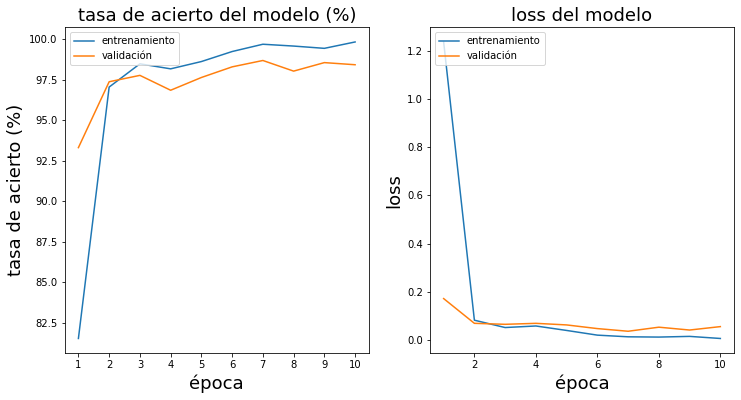

In [ ]:
base_model = train_covid(densenet121, loss_fn, optimizer, epochs=10)

RESULTADOS OBTENIDOS

In [ ]:
densenet121.eval()
correct = 0
total = 0
y_pred = []
y_real = []
with torch.no_grad():
  for data in test_loader:
    #inputs para la evaluación
    images, labels = data
    outputs = densenet121(images)
    _, predicted = torch.max(outputs, 1)
    total += labels.size(0)
    #Para calcular las correctas encuentra la suma cuando las etiquetas son iguales a las predecidas calculadas anteriormente
    correct += (predicted == labels).sum().item()
    y_pred.extend(predicted.numpy().tolist())
    y_real.extend(labels.numpy().tolist())
    #y_pred.extend(predicted.numpy().tolist())
#Dividimos correctas entre totales para calcular la precisión
  print('Accuracy of the network on the test images: %d %%' % (
      100 * correct / total))

Accuracy of the network on the test images: 99 %


(array([346.,   0.,   0.,   0.,   0., 217.,   0.,   0.,   0., 199.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

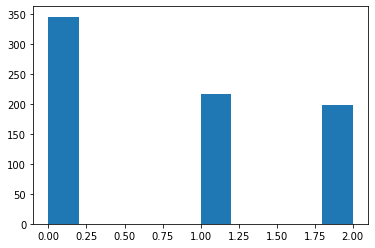

In [ ]:
import matplotlib.pyplot as plt
plt.hist(y_pred)


CLASSIFICATION REPORT

In [ ]:
print(classification_report(y_pred, y_real))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       346
           1       1.00      0.97      0.99       217
           2       0.97      1.00      0.98       199

    accuracy                           0.99       762
   macro avg       0.99      0.99      0.99       762
weighted avg       0.99      0.99      0.99       762



In [ ]:
print(y_real)

[2, 0, 0, 0, 1, 1, 0, 2, 2, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 2, 1, 2, 1, 0, 2, 0, 1, 2, 2, 2, 1, 0, 0, 2, 1, 2, 0, 2, 0, 2, 0, 0, 0, 0, 1, 1, 2, 0, 0, 2, 2, 2, 0, 0, 0, 0, 2, 1, 2, 1, 1, 1, 2, 1, 0, 2, 0, 2, 1, 1, 1, 0, 2, 2, 0, 0, 2, 1, 1, 0, 1, 0, 2, 0, 0, 0, 2, 1, 1, 1, 0, 0, 1, 2, 0, 0, 1, 2, 0, 0, 0, 1, 0, 1, 2, 0, 2, 1, 2, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 2, 0, 1, 2, 0, 1, 1, 2, 0, 0, 0, 1, 1, 1, 1, 0, 2, 1, 2, 2, 2, 0, 0, 0, 0, 2, 1, 2, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 0, 2, 0, 2, 0, 0, 0, 2, 2, 1, 0, 0, 0, 1, 2, 0, 0, 0, 0, 2, 1, 1, 2, 0, 0, 2, 0, 1, 0, 2, 1, 1, 0, 2, 0, 0, 2, 1, 2, 1, 2, 0, 1, 1, 2, 0, 1, 0, 1, 2, 0, 0, 0, 0, 1, 0, 2, 0, 1, 0, 0, 0, 2, 0, 2, 0, 2, 0, 2, 2, 0, 2, 1, 2, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 1, 0, 2, 0, 2, 1, 0, 2, 1, 0, 1, 0, 0, 1, 1, 0, 0, 2, 2, 0, 1, 0, 0, 0, 2, 1, 0, 2, 1, 0, 2, 0, 0, 2, 0, 0, 0, 2, 1, 1, 0, 0, 2, 2, 0, 1, 0, 0, 1, 0, 2, 2, 2, 2, 2, 0, 2, 1, 1, 2, 2, 2, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 2, 1, 2, 0, 1, 2, 2, 

In [ ]:
print(y_pred)

[2, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 2, 1, 2, 1, 0, 0, 0, 1, 0, 2, 2, 1, 0, 0, 2, 1, 2, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 2, 1, 2, 1, 1, 1, 1, 1, 0, 2, 0, 1, 1, 1, 1, 0, 2, 0, 0, 0, 2, 1, 1, 0, 0, 0, 2, 0, 0, 0, 2, 1, 1, 1, 0, 0, 1, 2, 0, 0, 1, 2, 0, 0, 0, 1, 0, 1, 2, 0, 2, 1, 2, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 2, 0, 1, 2, 0, 1, 1, 2, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 2, 0, 0, 0, 0, 0, 0, 1, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 2, 1, 1, 0, 2, 0, 0, 2, 1, 2, 1, 2, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 2, 1, 2, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 2, 1, 0, 2, 2, 0, 1, 0, 0, 1, 1, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 1, 0, 0, 1, 0, 2, 0, 0, 1, 0, 0, 0, 2, 1, 1, 0, 0, 2, 2, 0, 1, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 2, 1, 1, 2, 2, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 

MATRIZ DE CONFUSIÓN

In [ ]:

conf_matrix= confusion_matrix(y_pred, y_real)

In [ ]:
dataset_indices=dataset.class_to_idx
import seaborn as sn

In [ ]:
print(dataset_indices)

{'COVID': 0, 'NORMAL': 1, 'Viral Pneumonia': 2}


In [ ]:
conf_matrix = pd.DataFrame(conf_matrix, columns=['COVID', 'NORMAL', 'PNEUMONIA'], index=dataset_indices)
conf_matrix


,COVID,NORMAL,PNEUMONIA
COVID,345,0,1
NORMAL,0,211,6
Viral Pneumonia,0,0,199


[Text(32.99999999999999, 0.5, 'True label'),
 Text(0.5, 15.0, 'Predicted label')]

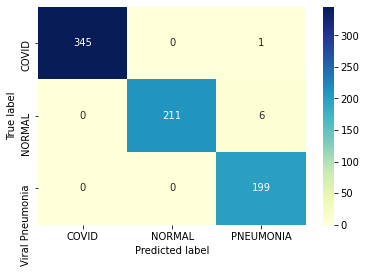

In [ ]:
conf_matrix2 = pd.DataFrame(conf_matrix, columns=['COVID', 'NORMAL', 'PNEUMONIA'], index=dataset_indices)
ax = sn.heatmap(conf_matrix2, annot=True, cmap='YlGnBu', fmt='g')
ax.set(xlabel='Predicted label', ylabel='True label')

HEATMAP

In [ ]:
class DenseNet(nn.Module):
    def __init__(self):
        super(DenseNet, self).__init__()
        
        #Seleccionamos la última capa de la red densenet
        self.densenet = torchvision.models.densenet201(pretrained=True)
        self.features_conv = self.densenet.features
        
        # Aplicamos el average pooling
        self.global_avg_pool = nn.AvgPool2d(kernel_size=7, stride=1)
        
        #Cogemos el clasificador y asignamos los gradientes a 0
        self.classifier = self.densenet.classifier
        self.gradients = None
    
    # hook para las activaciones de los gradientes
    def activations_hook(self, grad):
        self.gradients = grad
        
    def forward(self, x):
        x = self.features_conv(x)
        h = x.register_hook(self.activations_hook)
        x = self.global_avg_pool(x)
        x = x.view((1, 1920))
        x = self.classifier(x)
        return x
    
    def get_activations_gradient(self):
        return self.gradients
    
    def get_activations(self, x):
        return self.features_conv(x)

In [ ]:
batch_size = 1
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle = True)
val_loader = DataLoader(val_ds, batch_size = batch_size, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle = True)

In [ ]:
densenet = DenseNet()
densenet.eval()
img, _ = next(iter(test_loader))
pred = densenet(img)
pred_idx = pred.argmax(dim=1)
pred[:, pred_idx].backward()
gradients = densenet.get_activations_gradient()
gradients

tensor([[[[ 6.6484e-08,  6.6484e-08,  6.6484e-08,  ...,  6.6484e-08,
            6.6484e-08,  6.6484e-08],
          [ 6.6484e-08,  6.6484e-08,  6.6484e-08,  ...,  6.6484e-08,
            6.6484e-08,  6.6484e-08],
          [ 6.6484e-08,  6.6484e-08,  6.6484e-08,  ...,  6.6484e-08,
            6.6484e-08,  6.6484e-08],
          ...,
          [ 6.6484e-08,  6.6484e-08,  6.6484e-08,  ...,  6.6484e-08,
            6.6484e-08,  6.6484e-08],
          [ 6.6484e-08,  6.6484e-08,  6.6484e-08,  ...,  6.6484e-08,
            6.6484e-08,  6.6484e-08],
          [ 6.6484e-08,  6.6484e-08,  6.6484e-08,  ...,  6.6484e-08,
            6.6484e-08,  6.6484e-08]],

         [[ 3.3534e-07,  3.3534e-07,  3.3534e-07,  ...,  3.3534e-07,
            3.3534e-07,  3.3534e-07],
          [ 3.3534e-07,  3.3534e-07,  3.3534e-07,  ...,  3.3534e-07,
            3.3534e-07,  3.3534e-07],
          [ 3.3534e-07,  3.3534e-07,  3.3534e-07,  ...,  3.3534e-07,
            3.3534e-07,  3.3534e-07],
          ...,
     

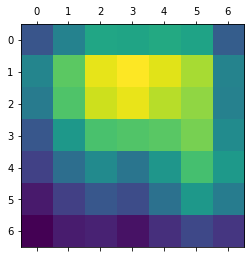

In [ ]:


# Extraemos los gradientes del modelo y los pasamos por los canales
gradients = densenet.get_activations_gradient()
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

# Realizamos la activación de la última capa
activations = densenet.get_activations(img).detach()

for i in range(512):
    activations[:, i, :, :] *= pooled_gradients[i]
heatmap = torch.mean(activations, dim=1).squeeze()

heatmap = np.maximum(heatmap, 0)
heatmap /= torch.max(heatmap)
plt.matshow(heatmap.squeeze())

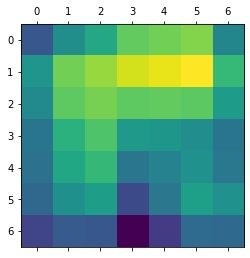

In [ ]:
#MAPA DE CALOR PNEUMONIA
gradients = densenet.get_activations_gradient()
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
activations = densenet.get_activations(img).detach()

for i in range(512):
    activations[:, i, :, :] *= pooled_gradients[i]
heatmap = torch.mean(activations, dim=1).squeeze()

heatmap = np.maximum(heatmap, 0)
heatmap /= torch.max(heatmap)
plt.matshow(heatmap.squeeze())

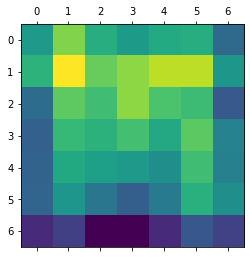

In [ ]:
#MAPA DE CALOR NORMAL
gradients = densenet.get_activations_gradient()
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

activations = densenet.get_activations(img).detach()

for i in range(512):
    activations[:, i, :, :] *= pooled_gradients[i]
heatmap = torch.mean(activations, dim=1).squeeze()

heatmap = np.maximum(heatmap, 0)
heatmap /= torch.max(heatmap)
plt.matshow(heatmap.squeeze())

In [ ]:

import cv2
img = cv2.imread('/GRAD_CAM/COVID/COVID (1000).png')
height, width, _ = img.shape
heatmap = cv2.applyColorMap(
cv2.resize(img[0],(width, height)), cv2.COLOR_BGR2GRAY)
result = heatmap + img 
cv2.imwrite('/GRAD_CAM/COVID/CAM2.png', result)
result

array([[[218,  46, 232],
        [219,  47, 233],
        [216,  44, 230],
        ...,
        [ 37, 121,  51],
        [239,  67, 253],
        [182,  10, 196]],

       [[230,  58, 245],
        [237,  65, 252],
        [229,  57, 244],
        ...,
        [ 36, 120,  51],
        [242,  70,   1],
        [179,   7, 194]],

       [[231,  57, 243],
        [227,  53, 239],
        [234,  60, 246],
        ...,
        [ 37, 119,  49],
        [244,  70,   0],
        [179,   5, 191]],

       ...,

       [[241, 106,  74],
        [246, 111,  79],
        [249, 114,  82],
        ...,
        [216,  81,  49],
        [198,  63,  31],
        [181,  46,  14]],

       [[191,  29, 226],
        [192,  30, 227],
        [191,  29, 226],
        ...,
        [181,  19, 216],
        [179,  17, 214],
        [168,   6, 203]],

       [[168, 234, 146],
        [169, 235, 147],
        [169, 235, 147],
        ...,
        [155, 221, 133],
        [154, 220, 132],
        [150, 216, 128]]

IMAGEN COVID APLICANDO MAPA DE CALOR

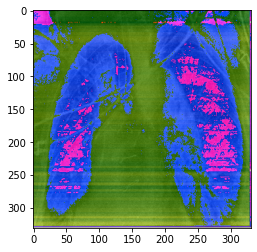

In [ ]:
image = plt.imread('/GRAD_CAM/COVID/CAM2.png')
plt.imshow(image)

IMAGEN PNEUMONIA APLICANDO MAPA DE CALOR

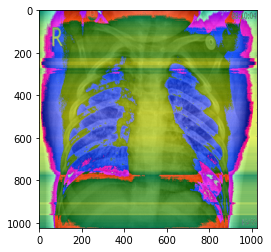

In [ ]:
image = plt.imread('/bin/GRAD_CAM/VIRAL/pneumonia.png')
plt.imshow(image)

IMAGEN NORMAL APLICANDO MAPA DE CALOR

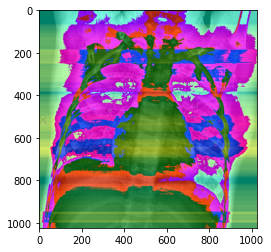

In [ ]:
image = plt.imread('/bin/GRAD_CAM/NORMAL/normal2.png')
plt.imshow(image)

VISUALIZACIÓN DE LAS PREDICCIONES

In [ ]:
n_train =4971
n_valid = 100
n_test = 9

In [ ]:
train_ds, val_ds, test_ds = torch.utils.data.random_split(dataset, [n_train, n_valid, n_test])

In [ ]:
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle = True)

In [ ]:
class_names=dataset.classes
def show_images(images, labels, preds):
    plt.figure(figsize=(20,10))

    for i, image in enumerate(images): 
        plt.subplot(3,3,i+1, xticks=[], yticks=[])
        image=image.numpy().transpose((1,2,0))
        plt.imshow(image)
        col = 'green' if preds[i]==labels[i] else 'red'
        plt.xlabel(f'Actual : {class_names[int(labels[i].numpy())]}/ Predicted: {class_names[int(preds[i].numpy())]}', color=col)
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


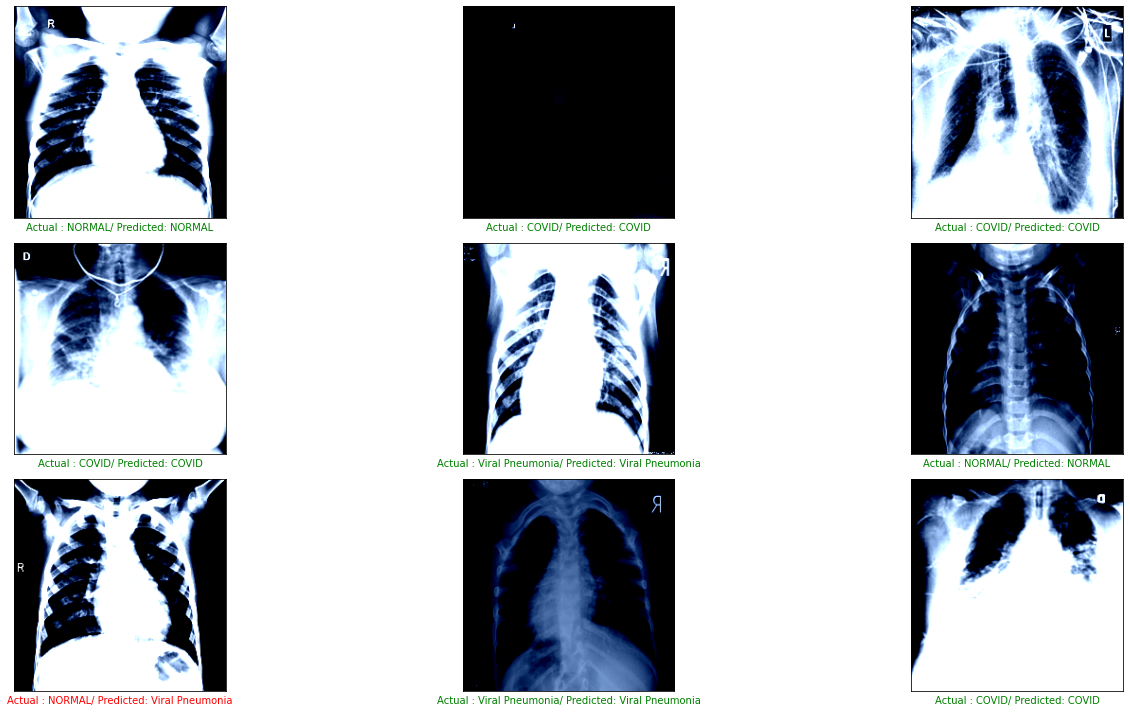

In [ ]:
def show_preds() :
  densenet121.eval()
  images, labels = next(iter(test_loader))
  outputs = densenet121(images)
  _, preds = torch.max(outputs, 1)
  show_images(images, labels, preds)
show_preds()